In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from torch.amp import autocast, GradScaler

#### Section 1

In [3]:
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
])

trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=train_transform)
testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=test_transform)

batch_size = 512
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)


classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

data_iter = iter(trainloader)
images, labels = next(data_iter)
print("Batch of images shape:", images.shape)
print("Batch of labels shape:", labels.shape)

100.0%


Batch of images shape: torch.Size([512, 3, 32, 32])
Batch of labels shape: torch.Size([512])


#### Section 2

In [4]:
class IntermediateBlock(nn.Module):
    def __init__(self, in_channels, out_channels, num_convs):
        super().__init__()
        self.convs = nn.ModuleList()
        for _ in range(num_convs):
            conv = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 3, padding=1, bias=False),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
            )
            nn.init.kaiming_normal_(conv[0].weight, mode='fan_out', nonlinearity='relu')
            self.convs.append(conv)

        self.weight_generator = nn.Sequential(
            nn.Linear(in_channels, 128),
            nn.ReLU(),
            nn.Linear(128, num_convs)
        )

    def forward(self, x):
        conv_outputs = [conv(x) for conv in self.convs]
        m = torch.mean(x, dim=[2, 3])
        weights = torch.softmax(self.weight_generator(m), dim=1)

        weights = weights.view(-1, len(self.convs), 1, 1, 1)
        weighted_outputs = torch.stack(conv_outputs, dim=1) * weights
        return torch.sum(weighted_outputs, dim=1)

class OutputBlock(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(in_channels, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        m = torch.mean(x, dim=[2, 3])
        return self.fc(m)

model = nn.Sequential(
    IntermediateBlock(3, 64, 4),
    IntermediateBlock(64, 128, 4),
    IntermediateBlock(128, 256, 4),
    IntermediateBlock(256, 512, 4),
    OutputBlock(512)
)


#### Section 3

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
scaler = GradScaler(device='cuda')

optimizer = optim.SGD(model.parameters(), lr=0.15, momentum=0.95, nesterov = True, weight_decay=1e-3)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.15, pct_start = 0.3, div_factor=25, final_div_factor=1e4, steps_per_epoch=len(trainloader), epochs=100)
criterion = nn.CrossEntropyLoss(label_smoothing=0.2)

train_loss, train_acc, test_acc = [], [], []
best_acc = 0

for epoch in range(100):
    model.train()
    total, correct = 0, 0

    for inputs, labels in tqdm(trainloader, desc=f'Epoch {epoch+1}/100'):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        with autocast(device_type='cuda'):
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()

        train_loss.append(loss.item())
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_acc.append(100 * correct / total)

    model.eval()
    total_test, correct_test = 0, 0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total_test += labels.size(0)
            correct_test += predicted.eq(labels).sum().item()

    acc = 100 * correct_test / total_test
    test_acc.append(acc)
    best_acc = max(best_acc, acc)

    print(f"Epoch {epoch+1}: Train Acc: {train_acc[-1]:.2f}% | "
          f"Test Acc: {acc:.2f}% | Best: {best_acc:.2f}%")

Epoch 1/100:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 1/100: 100%|██████████| 98/98 [00:15<00:00,  6.40it/s]


Epoch 1: Train Acc: 24.16% | Test Acc: 30.62% | Best: 30.62%


Epoch 2/100: 100%|██████████| 98/98 [00:11<00:00,  8.19it/s]


Epoch 2: Train Acc: 34.85% | Test Acc: 41.30% | Best: 41.30%


Epoch 3/100: 100%|██████████| 98/98 [00:12<00:00,  8.15it/s]


Epoch 3: Train Acc: 41.01% | Test Acc: 42.49% | Best: 42.49%


Epoch 4/100: 100%|██████████| 98/98 [00:12<00:00,  8.13it/s]


Epoch 4: Train Acc: 45.44% | Test Acc: 46.00% | Best: 46.00%


Epoch 5/100: 100%|██████████| 98/98 [00:12<00:00,  8.16it/s]


Epoch 5: Train Acc: 48.76% | Test Acc: 48.51% | Best: 48.51%


Epoch 6/100: 100%|██████████| 98/98 [00:12<00:00,  8.15it/s]


Epoch 6: Train Acc: 51.32% | Test Acc: 52.92% | Best: 52.92%


Epoch 7/100: 100%|██████████| 98/98 [00:12<00:00,  8.07it/s]


Epoch 7: Train Acc: 53.00% | Test Acc: 52.17% | Best: 52.92%


Epoch 8/100: 100%|██████████| 98/98 [00:12<00:00,  8.06it/s]


Epoch 8: Train Acc: 54.52% | Test Acc: 46.23% | Best: 52.92%


Epoch 9/100: 100%|██████████| 98/98 [00:12<00:00,  8.05it/s]


Epoch 9: Train Acc: 56.06% | Test Acc: 47.75% | Best: 52.92%


Epoch 10/100: 100%|██████████| 98/98 [00:12<00:00,  8.04it/s]


Epoch 10: Train Acc: 57.24% | Test Acc: 45.15% | Best: 52.92%


Epoch 11/100: 100%|██████████| 98/98 [00:12<00:00,  8.03it/s]


Epoch 11: Train Acc: 58.61% | Test Acc: 52.00% | Best: 52.92%


Epoch 12/100: 100%|██████████| 98/98 [00:12<00:00,  8.11it/s]


Epoch 12: Train Acc: 59.61% | Test Acc: 32.19% | Best: 52.92%


Epoch 13/100: 100%|██████████| 98/98 [00:12<00:00,  8.11it/s]


Epoch 13: Train Acc: 61.02% | Test Acc: 46.06% | Best: 52.92%


Epoch 14/100: 100%|██████████| 98/98 [00:12<00:00,  8.11it/s]


Epoch 14: Train Acc: 62.71% | Test Acc: 42.37% | Best: 52.92%


Epoch 15/100: 100%|██████████| 98/98 [00:12<00:00,  8.10it/s]


Epoch 15: Train Acc: 63.92% | Test Acc: 51.99% | Best: 52.92%


Epoch 16/100: 100%|██████████| 98/98 [00:12<00:00,  8.09it/s]


Epoch 16: Train Acc: 65.02% | Test Acc: 31.06% | Best: 52.92%


Epoch 17/100: 100%|██████████| 98/98 [00:12<00:00,  8.10it/s]


Epoch 17: Train Acc: 65.75% | Test Acc: 36.75% | Best: 52.92%


Epoch 18/100: 100%|██████████| 98/98 [00:12<00:00,  8.08it/s]


Epoch 18: Train Acc: 66.85% | Test Acc: 43.51% | Best: 52.92%


Epoch 19/100: 100%|██████████| 98/98 [00:12<00:00,  8.09it/s]


Epoch 19: Train Acc: 67.71% | Test Acc: 50.80% | Best: 52.92%


Epoch 20/100: 100%|██████████| 98/98 [00:12<00:00,  8.08it/s]


Epoch 20: Train Acc: 69.31% | Test Acc: 40.38% | Best: 52.92%


Epoch 21/100: 100%|██████████| 98/98 [00:12<00:00,  8.09it/s]


Epoch 21: Train Acc: 69.86% | Test Acc: 31.84% | Best: 52.92%


Epoch 22/100: 100%|██████████| 98/98 [00:12<00:00,  8.09it/s]


Epoch 22: Train Acc: 70.67% | Test Acc: 38.63% | Best: 52.92%


Epoch 23/100: 100%|██████████| 98/98 [00:12<00:00,  8.10it/s]


Epoch 23: Train Acc: 71.35% | Test Acc: 42.14% | Best: 52.92%


Epoch 24/100: 100%|██████████| 98/98 [00:12<00:00,  8.09it/s]


Epoch 24: Train Acc: 72.40% | Test Acc: 30.21% | Best: 52.92%


Epoch 25/100: 100%|██████████| 98/98 [00:12<00:00,  8.08it/s]


Epoch 25: Train Acc: 72.86% | Test Acc: 24.26% | Best: 52.92%


Epoch 26/100: 100%|██████████| 98/98 [00:12<00:00,  8.08it/s]


Epoch 26: Train Acc: 73.99% | Test Acc: 24.73% | Best: 52.92%


Epoch 27/100: 100%|██████████| 98/98 [00:12<00:00,  8.09it/s]


Epoch 27: Train Acc: 74.46% | Test Acc: 37.00% | Best: 52.92%


Epoch 28/100: 100%|██████████| 98/98 [00:12<00:00,  8.10it/s]


Epoch 28: Train Acc: 75.23% | Test Acc: 45.45% | Best: 52.92%


Epoch 29/100: 100%|██████████| 98/98 [00:12<00:00,  8.08it/s]


Epoch 29: Train Acc: 76.21% | Test Acc: 48.08% | Best: 52.92%


Epoch 30/100: 100%|██████████| 98/98 [00:12<00:00,  8.08it/s]


Epoch 30: Train Acc: 76.41% | Test Acc: 46.89% | Best: 52.92%


Epoch 31/100: 100%|██████████| 98/98 [00:12<00:00,  8.10it/s]


Epoch 31: Train Acc: 77.27% | Test Acc: 32.10% | Best: 52.92%


Epoch 32/100: 100%|██████████| 98/98 [00:12<00:00,  8.09it/s]


Epoch 32: Train Acc: 77.63% | Test Acc: 56.65% | Best: 56.65%


Epoch 33/100: 100%|██████████| 98/98 [00:12<00:00,  8.10it/s]


Epoch 33: Train Acc: 78.29% | Test Acc: 40.25% | Best: 56.65%


Epoch 34/100: 100%|██████████| 98/98 [00:12<00:00,  8.10it/s]


Epoch 34: Train Acc: 78.86% | Test Acc: 49.60% | Best: 56.65%


Epoch 35/100: 100%|██████████| 98/98 [00:12<00:00,  8.09it/s]


Epoch 35: Train Acc: 79.51% | Test Acc: 45.22% | Best: 56.65%


Epoch 36/100: 100%|██████████| 98/98 [00:12<00:00,  8.10it/s]


Epoch 36: Train Acc: 79.89% | Test Acc: 47.90% | Best: 56.65%


Epoch 37/100: 100%|██████████| 98/98 [00:12<00:00,  8.11it/s]


Epoch 37: Train Acc: 80.37% | Test Acc: 66.16% | Best: 66.16%


Epoch 38/100: 100%|██████████| 98/98 [00:12<00:00,  8.12it/s]


Epoch 38: Train Acc: 80.90% | Test Acc: 71.28% | Best: 71.28%


Epoch 39/100: 100%|██████████| 98/98 [00:12<00:00,  8.12it/s]


Epoch 39: Train Acc: 81.27% | Test Acc: 63.72% | Best: 71.28%


Epoch 40/100: 100%|██████████| 98/98 [00:12<00:00,  8.11it/s]


Epoch 40: Train Acc: 81.51% | Test Acc: 63.05% | Best: 71.28%


Epoch 41/100: 100%|██████████| 98/98 [00:12<00:00,  8.11it/s]


Epoch 41: Train Acc: 81.86% | Test Acc: 61.62% | Best: 71.28%


Epoch 42/100: 100%|██████████| 98/98 [00:12<00:00,  8.13it/s]


Epoch 42: Train Acc: 82.23% | Test Acc: 55.47% | Best: 71.28%


Epoch 43/100: 100%|██████████| 98/98 [00:12<00:00,  8.13it/s]


Epoch 43: Train Acc: 82.67% | Test Acc: 59.22% | Best: 71.28%


Epoch 44/100: 100%|██████████| 98/98 [00:12<00:00,  8.12it/s]


Epoch 44: Train Acc: 82.88% | Test Acc: 62.95% | Best: 71.28%


Epoch 45/100: 100%|██████████| 98/98 [00:12<00:00,  8.12it/s]


Epoch 45: Train Acc: 82.89% | Test Acc: 65.38% | Best: 71.28%


Epoch 46/100: 100%|██████████| 98/98 [00:12<00:00,  8.14it/s]


Epoch 46: Train Acc: 83.47% | Test Acc: 72.05% | Best: 72.05%


Epoch 47/100: 100%|██████████| 98/98 [00:12<00:00,  8.12it/s]


Epoch 47: Train Acc: 83.60% | Test Acc: 62.34% | Best: 72.05%


Epoch 48/100: 100%|██████████| 98/98 [00:12<00:00,  8.11it/s]


Epoch 48: Train Acc: 83.83% | Test Acc: 68.27% | Best: 72.05%


Epoch 49/100: 100%|██████████| 98/98 [00:12<00:00,  8.12it/s]


Epoch 49: Train Acc: 83.98% | Test Acc: 67.91% | Best: 72.05%


Epoch 50/100: 100%|██████████| 98/98 [00:12<00:00,  8.12it/s]


Epoch 50: Train Acc: 84.38% | Test Acc: 44.68% | Best: 72.05%


Epoch 51/100: 100%|██████████| 98/98 [00:12<00:00,  8.12it/s]


Epoch 51: Train Acc: 84.55% | Test Acc: 74.72% | Best: 74.72%


Epoch 52/100: 100%|██████████| 98/98 [00:12<00:00,  8.13it/s]


Epoch 52: Train Acc: 84.98% | Test Acc: 69.94% | Best: 74.72%


Epoch 53/100: 100%|██████████| 98/98 [00:12<00:00,  8.12it/s]


Epoch 53: Train Acc: 84.95% | Test Acc: 56.58% | Best: 74.72%


Epoch 54/100: 100%|██████████| 98/98 [00:12<00:00,  8.12it/s]


Epoch 54: Train Acc: 85.30% | Test Acc: 54.67% | Best: 74.72%


Epoch 55/100: 100%|██████████| 98/98 [00:12<00:00,  8.12it/s]


Epoch 55: Train Acc: 85.61% | Test Acc: 66.34% | Best: 74.72%


Epoch 56/100: 100%|██████████| 98/98 [00:12<00:00,  8.12it/s]


Epoch 56: Train Acc: 85.88% | Test Acc: 67.70% | Best: 74.72%


Epoch 57/100: 100%|██████████| 98/98 [00:12<00:00,  8.12it/s]


Epoch 57: Train Acc: 86.08% | Test Acc: 76.75% | Best: 76.75%


Epoch 58/100: 100%|██████████| 98/98 [00:12<00:00,  8.13it/s]


Epoch 58: Train Acc: 86.29% | Test Acc: 67.75% | Best: 76.75%


Epoch 59/100: 100%|██████████| 98/98 [00:12<00:00,  8.13it/s]


Epoch 59: Train Acc: 86.49% | Test Acc: 64.34% | Best: 76.75%


Epoch 60/100: 100%|██████████| 98/98 [00:12<00:00,  8.13it/s]


Epoch 60: Train Acc: 86.53% | Test Acc: 47.76% | Best: 76.75%


Epoch 61/100: 100%|██████████| 98/98 [00:12<00:00,  8.13it/s]


Epoch 61: Train Acc: 86.97% | Test Acc: 60.98% | Best: 76.75%


Epoch 62/100: 100%|██████████| 98/98 [00:12<00:00,  8.13it/s]


Epoch 62: Train Acc: 87.42% | Test Acc: 75.49% | Best: 76.75%


Epoch 63/100: 100%|██████████| 98/98 [00:12<00:00,  8.13it/s]


Epoch 63: Train Acc: 87.18% | Test Acc: 69.07% | Best: 76.75%


Epoch 64/100: 100%|██████████| 98/98 [00:12<00:00,  8.12it/s]


Epoch 64: Train Acc: 87.71% | Test Acc: 76.44% | Best: 76.75%


Epoch 65/100: 100%|██████████| 98/98 [00:12<00:00,  8.11it/s]


Epoch 65: Train Acc: 87.84% | Test Acc: 60.25% | Best: 76.75%


Epoch 66/100: 100%|██████████| 98/98 [00:12<00:00,  8.11it/s]


Epoch 66: Train Acc: 88.09% | Test Acc: 71.92% | Best: 76.75%


Epoch 67/100: 100%|██████████| 98/98 [00:12<00:00,  8.13it/s]


Epoch 67: Train Acc: 88.20% | Test Acc: 72.05% | Best: 76.75%


Epoch 68/100: 100%|██████████| 98/98 [00:12<00:00,  8.12it/s]


Epoch 68: Train Acc: 88.59% | Test Acc: 78.42% | Best: 78.42%


Epoch 69/100: 100%|██████████| 98/98 [00:12<00:00,  8.13it/s]


Epoch 69: Train Acc: 88.80% | Test Acc: 69.10% | Best: 78.42%


Epoch 70/100: 100%|██████████| 98/98 [00:12<00:00,  8.13it/s]


Epoch 70: Train Acc: 89.15% | Test Acc: 78.29% | Best: 78.42%


Epoch 71/100: 100%|██████████| 98/98 [00:12<00:00,  8.13it/s]


Epoch 71: Train Acc: 89.43% | Test Acc: 74.78% | Best: 78.42%


Epoch 72/100: 100%|██████████| 98/98 [00:12<00:00,  8.13it/s]


Epoch 72: Train Acc: 89.67% | Test Acc: 81.43% | Best: 81.43%


Epoch 73/100: 100%|██████████| 98/98 [00:12<00:00,  8.13it/s]


Epoch 73: Train Acc: 89.76% | Test Acc: 80.83% | Best: 81.43%


Epoch 74/100: 100%|██████████| 98/98 [00:12<00:00,  8.12it/s]


Epoch 74: Train Acc: 90.06% | Test Acc: 84.47% | Best: 84.47%


Epoch 75/100: 100%|██████████| 98/98 [00:12<00:00,  8.13it/s]


Epoch 75: Train Acc: 90.43% | Test Acc: 83.05% | Best: 84.47%


Epoch 76/100: 100%|██████████| 98/98 [00:12<00:00,  8.13it/s]


Epoch 76: Train Acc: 90.99% | Test Acc: 78.49% | Best: 84.47%


Epoch 77/100: 100%|██████████| 98/98 [00:12<00:00,  8.13it/s]


Epoch 77: Train Acc: 91.24% | Test Acc: 82.02% | Best: 84.47%


Epoch 78/100: 100%|██████████| 98/98 [00:12<00:00,  8.12it/s]


Epoch 78: Train Acc: 91.40% | Test Acc: 79.65% | Best: 84.47%


Epoch 79/100: 100%|██████████| 98/98 [00:12<00:00,  8.12it/s]


Epoch 79: Train Acc: 92.00% | Test Acc: 75.56% | Best: 84.47%


Epoch 80/100: 100%|██████████| 98/98 [00:12<00:00,  8.13it/s]


Epoch 80: Train Acc: 92.42% | Test Acc: 74.88% | Best: 84.47%


Epoch 81/100: 100%|██████████| 98/98 [00:12<00:00,  8.13it/s]


Epoch 81: Train Acc: 92.64% | Test Acc: 77.42% | Best: 84.47%


Epoch 82/100: 100%|██████████| 98/98 [00:12<00:00,  8.13it/s]


Epoch 82: Train Acc: 92.93% | Test Acc: 80.11% | Best: 84.47%


Epoch 83/100: 100%|██████████| 98/98 [00:12<00:00,  8.14it/s]


Epoch 83: Train Acc: 93.41% | Test Acc: 83.75% | Best: 84.47%


Epoch 84/100: 100%|██████████| 98/98 [00:12<00:00,  8.13it/s]


Epoch 84: Train Acc: 93.86% | Test Acc: 80.07% | Best: 84.47%


Epoch 85/100: 100%|██████████| 98/98 [00:12<00:00,  8.13it/s]


Epoch 85: Train Acc: 94.25% | Test Acc: 79.37% | Best: 84.47%


Epoch 86/100: 100%|██████████| 98/98 [00:12<00:00,  8.12it/s]


Epoch 86: Train Acc: 94.73% | Test Acc: 84.26% | Best: 84.47%


Epoch 87/100: 100%|██████████| 98/98 [00:12<00:00,  8.11it/s]


Epoch 87: Train Acc: 95.09% | Test Acc: 84.02% | Best: 84.47%


Epoch 88/100: 100%|██████████| 98/98 [00:12<00:00,  8.11it/s]


Epoch 88: Train Acc: 95.45% | Test Acc: 84.48% | Best: 84.48%


Epoch 89/100: 100%|██████████| 98/98 [00:12<00:00,  8.11it/s]


Epoch 89: Train Acc: 95.95% | Test Acc: 84.49% | Best: 84.49%


Epoch 90/100: 100%|██████████| 98/98 [00:12<00:00,  8.12it/s]


Epoch 90: Train Acc: 96.16% | Test Acc: 87.45% | Best: 87.45%


Epoch 91/100: 100%|██████████| 98/98 [00:12<00:00,  8.11it/s]


Epoch 91: Train Acc: 96.70% | Test Acc: 87.46% | Best: 87.46%


Epoch 92/100: 100%|██████████| 98/98 [00:12<00:00,  8.13it/s]


Epoch 92: Train Acc: 97.03% | Test Acc: 89.11% | Best: 89.11%


Epoch 93/100: 100%|██████████| 98/98 [00:12<00:00,  8.11it/s]


Epoch 93: Train Acc: 97.31% | Test Acc: 88.82% | Best: 89.11%


Epoch 94/100: 100%|██████████| 98/98 [00:12<00:00,  8.11it/s]


Epoch 94: Train Acc: 97.43% | Test Acc: 89.63% | Best: 89.63%


Epoch 95/100: 100%|██████████| 98/98 [00:12<00:00,  8.11it/s]


Epoch 95: Train Acc: 97.71% | Test Acc: 89.59% | Best: 89.63%


Epoch 96/100: 100%|██████████| 98/98 [00:12<00:00,  8.12it/s]


Epoch 96: Train Acc: 97.91% | Test Acc: 90.09% | Best: 90.09%


Epoch 97/100: 100%|██████████| 98/98 [00:12<00:00,  8.12it/s]


Epoch 97: Train Acc: 98.11% | Test Acc: 89.99% | Best: 90.09%


Epoch 98/100: 100%|██████████| 98/98 [00:12<00:00,  8.11it/s]


Epoch 98: Train Acc: 98.22% | Test Acc: 90.14% | Best: 90.14%


Epoch 99/100: 100%|██████████| 98/98 [00:12<00:00,  8.11it/s]


Epoch 99: Train Acc: 98.26% | Test Acc: 90.21% | Best: 90.21%


Epoch 100/100: 100%|██████████| 98/98 [00:12<00:00,  8.11it/s]


Epoch 100: Train Acc: 98.33% | Test Acc: 90.32% | Best: 90.32%


#### Visualizations

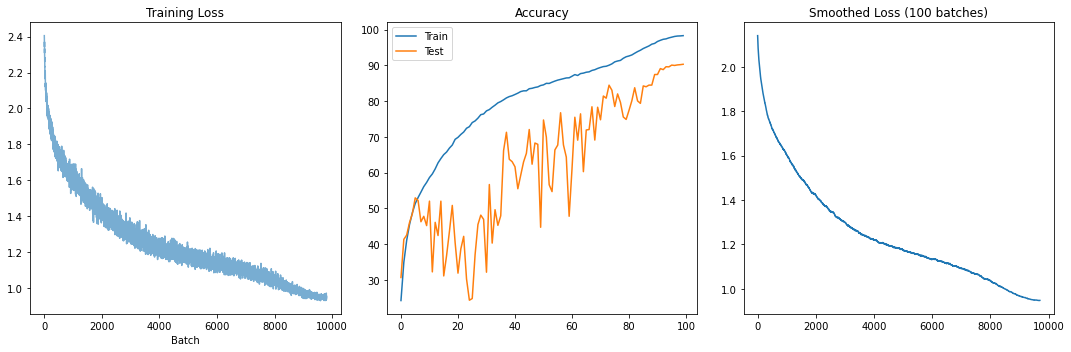


Final Report:
Highest Test Accuracy: 90.32%


In [6]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(train_loss, alpha=0.6)
plt.title('Training Loss')
plt.xlabel('Batch')

plt.subplot(1, 3, 2)
plt.plot(train_acc, label='Train')
plt.plot(test_acc, label='Test')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 3, 3)
smoothed = np.convolve(train_loss, np.ones(100)/100, mode='valid')
plt.plot(smoothed)
plt.title('Smoothed Loss (100 batches)')

plt.tight_layout()
plt.savefig('training_metrics.png')
plt.show()

print(f"\nFinal Report:")
print(f"Highest Test Accuracy: {best_acc:.2f}%")